In [46]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [47]:
# tf_flowers 데이터셋 로드
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


In [48]:
print(raw_train.element_spec)

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [49]:
# 이미지 크기 설정
IMG_SIZE = (224, 224) 

# 이미지를 같은 크기로 포맷팅하는 함수 정의
def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)  # 이미지를 tf.float32로 변환
    image = (image / 127.5) - 1  # 이미지를 -1~1 범위로 정규화
    return image, label

In [50]:
# 데이터셋에 이미지 포맷팅 적용
train_data = raw_train.map(format_image)
val_data = raw_validation.map(format_image)
test_data = raw_test.map(format_image)

In [51]:
print(train_data)
print(val_data)
print(test_data)

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [52]:
print(metadata.splits['train'].num_examples)


3670


In [53]:
# 훈련, 검증, 테스트 배치 준비
batch_size = 32  
train_data_batch = train_data.shuffle(4000).batch(batch_size)
val_data_batch = val_data.batch(batch_size)
test_data_batch = test_data.batch(batch_size)


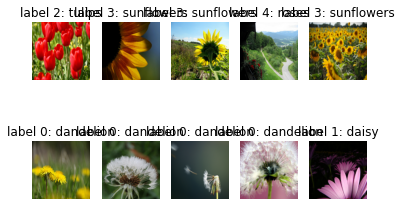

In [54]:
import matplotlib.pyplot as plt

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train_data.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image+1)/2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [55]:
# 클래스 학인
class_names = metadata.features['label'].names
print(class_names)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [56]:
from tensorflow.keras.applications import MobileNetV3Small, VGG16
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, GlobalMaxPooling2D

In [57]:
mobilenet = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
mobilenet.trainable = False
mobilenet_model = Sequential([mobilenet,
                             GlobalMaxPooling2D(),
                             Dense(1024,activation='relu'),
                              Dense(512,activation='relu'),
                              Dense(256,activation='relu'),
                              Dense(128,activation='relu'),
                             Dense(5,activation='softmax')])

# 모델 컴파일
mobilenet_model.compile(optimizer='adam', #tf.keras.optimizers.RMSprop(learning_rate=0.0001)
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 5)                

In [58]:
# 모델 훈련

history = mobilenet_model.fit(train_data_batch, epochs=10, validation_data=val_data_batch)

Epoch 1/10
92/92 [==============================] - 17s 141ms/step - loss: 0.8593 - accuracy: 0.6645 - val_loss: 0.6522 - val_accuracy: 0.7657
Epoch 2/10
92/92 [==============================] - 14s 138ms/step - loss: 0.4967 - accuracy: 0.8154 - val_loss: 0.5657 - val_accuracy: 0.7711
Epoch 3/10
92/92 [==============================] - 14s 140ms/step - loss: 0.3955 - accuracy: 0.8505 - val_loss: 0.4648 - val_accuracy: 0.8256
Epoch 4/10
92/92 [==============================] - 14s 138ms/step - loss: 0.3575 - accuracy: 0.8723 - val_loss: 0.4304 - val_accuracy: 0.8338
Epoch 5/10
92/92 [==============================] - 14s 138ms/step - loss: 0.3324 - accuracy: 0.8794 - val_loss: 0.4927 - val_accuracy: 0.8202
Epoch 6/10
92/92 [==============================] - 14s 138ms/step - loss: 0.3035 - accuracy: 0.8941 - val_loss: 0.6267 - val_accuracy: 0.7929
Epoch 7/10
92/92 [==============================] - 14s 138ms/step - loss: 0.2265 - accuracy: 0.9203 - val_loss: 0.6012 - val_accuracy: 0.8229

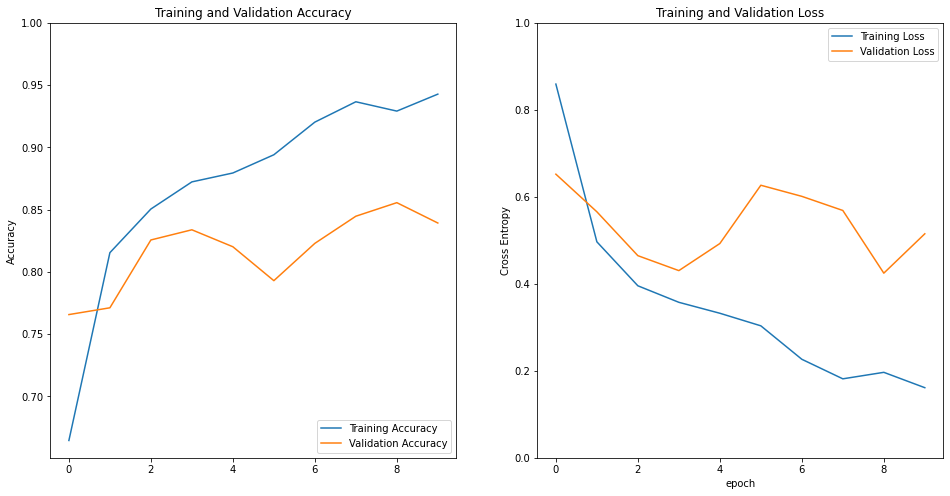

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [60]:
# 모델 평가
test_loss, test_accuracy = mobilenet_model.evaluate(test_data_batch)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

12/12 [==============================] - 2s 116ms/step - loss: 0.5299 - accuracy: 0.8610
Test Loss: 0.5299, Test Accuracy: 0.8610
